In [29]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage 

messages = [AIMessage(content=f"So you said you were researching ocean mammals?",name="Model")]
messages.append(HumanMessage(content=f"Yes , that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.",name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.",name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes , that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [30]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [31]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")

result = llm.invoke(messages)
result

AIMessage(content="<think>\nOkay, the user is interested in the best places to see orcas (killer whales) in the US. Let me start by recalling where orcas are commonly found. The Pacific Northwest is a big one, especially around Washington State and British Columbia. The Salish Sea comes to mind. Specific areas like the San Juan Islands are famous for whale watching. I should mention that the best time there is from May to October.\n\nThen there's Alaska. Glacier Bay and Icy Strait are popular spots there. The season there is a bit earlier, maybe April to September. I should note that Alaska's orcas might be different in behavior compared to the Salish Sea ones. Also, the orcas in Alaska include both transient and resident pods, which have different diets and behaviors.\n\nAnother spot is the Pacific Coast of Oregon and California. They have orcas too, but maybe less predictable. The Southern Resident Killer Whales are an endangered population in that area. I should mention the challeng

In [32]:
def add(a:int,b:int)->int:
    return a+b

In [33]:
llm_with_tools = llm.bind_tools([add])

In [34]:
llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3",name="Lance")])


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '92enrfcad', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 157, 'total_tokens': 304, 'completion_time': 0.236801734, 'prompt_time': 0.006241014, 'queue_time': 0.158727466, 'total_time': 0.243042748, 'completion_tokens_details': {'reasoning_tokens': 118}}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_2bfcc54d36', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-12f66cae-2d33-4f01-a0b1-4389a29a2d58-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': '92enrfcad', 'type': 'tool_call'}], usage_metadata={'input_tokens': 157, 'output_tokens': 147, 'total_tokens': 304})

In [35]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]

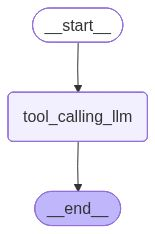

In [36]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

def tool_calling_llm(state:MessageState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessageState)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_edge(START,"tool_calling_llm")
builder.add_edge("tool_calling_llm",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
messages = graph.invoke({"messages":HumanMessage(content="what is 2 plus 3?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 2 plus 3?
================================== Ai Message ==================================
Tool Calls:
  add (6grgdrtws)
 Call ID: 6grgdrtws
  Args:
    a: 2
    b: 3


### Introducing Tool calling Node and condition

In [39]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [40]:
from langchain_openai import ChatOpenAI

def multiply(a:int,b:int)->int:
    """ 
    Multiply a and b.

    Args:
       a: first int
       b: second int
    """
    return a*b

In [42]:
llm_with_tools = llm.bind_tools([multiply])

In [53]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.graph import MessagesState

def tool_calling_llm(state:MessagesState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

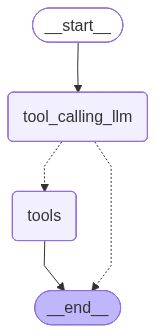

In [54]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode([multiply]))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
messages = graph.invoke({"messages":HumanMessage(content="what is 2 multiply by  2?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiply by  2?
================================== Ai Message ==================================
Tool Calls:
  multiply (3wcyvqavb)
 Call ID: 3wcyvqavb
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4
